In [204]:
import copy, os, gc
import numpy as np
import pickle as pkl
from time import time, sleep
from tqdm import tqdm

from IPython import display
from collections import Counter
from itertools import product, chain, combinations


#matplotlib
import matplotlib
import matplotlib as mp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter
%matplotlib inline

#https://matplotlib.org/users/customizing.html
matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.01
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['axes.titlesize'] = 20
# Configuring latex fonts
matplotlib.rc('font', **{'family':'serif'})
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', unicode=True)
matplotlib.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
matplotlib.rc('text.latex', preamble=r'\usepackage[english]{babel}')
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')


import sys
library_path = '../../'
if library_path not in sys.path:
    sys.path.append(library_path)

CIFAR10_DIR = library_path + 'datasets/CIFAR10'
MNIST_DIR   = library_path + 'datasets/MNIST'

from ml.utils import get_CIFAR10_data, get_MNIST_data
from ml.neural_network import Layer, Sequential, Model, Solver
from ml.neural_network.layers import Dense, Dropout, SoftMax, BatchNormalization
from ml.neural_network.nonlinearities import Tanh, ReLU, LeakyReLU, ELU, SoftPlus
from ml.neural_network.criterions import MSECriterion, MulticlassLogLoss
from ml.neural_network.regularizers import *
from ml.neural_network.initializers import *
from ml.neural_network.optimizers import *
from ml.neural_network.decorators import *
from ml.neural_network.gradients import *

In [2]:
def plot_solver_history(history, axarr=None, figsize=(10, 14), colors=None, markers=None):
    if axarr is None:
        _, axarr = plt.subplots(3, 1, figsize=figsize)
    plot_kwargs = {'markeredgecolor': 'k', 'ms': 5, 'alpha': 0.7}
    if colors is None: 
        colors = {'train': 'r', 'val': 'b'}
    if markers is None:
        markers = {'train': 'o', 'val': '^'}
        
    ax = axarr[0]  
    ax.plot(history['loss_history'], color=colors['train'])
    ax.set_yscale('log')
    ax.set_xlabel('iteration')
    ax.set_ylabel('loss')
    ax.set_title('Training loss vs iteration')
    ax.grid(linestyle='--', alpha=0.5)

    ax = axarr[1]
    for label in ['train', 'val']:
        data = history['{}_loss_history'.format(label)]
        ax.plot(data, marker=markers[label], color=colors[label], label=label, **plot_kwargs)
    ax.set_yscale('log')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.set_title('Loss vs epoch')
    ax.grid(linestyle='--', alpha=0.5)
    ax.legend(loc='upper right', fontsize=16)

    ax = axarr[2]
    for label in ['train', 'val']:
        data = history['{}_acc_history'.format(label)]
        ax.plot(data, marker=markers[label], color=colors[label], label=label, **plot_kwargs)
    ax.set_xlabel('epoch')
    ax.set_ylabel('training loss')
    ax.set_title('Accuracy vs epoch')
    ax.grid(linestyle='--', alpha=0.5)
    ax.legend(loc='lower right', fontsize=16)
    plt.tight_layout()
    plt.show()
    return axarr

<a id='cnn'></a>
# Convolutional Networks
So far we have worked with deep fully-connected networks, using them to explore different optimization strategies and network architectures. Fully-connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results use convolutional networks instead.

First you will implement several layer types that are used in convolutional networks. You will then use these layers to train a convolutional network on the CIFAR-10 dataset.

<a id='toc'></a>
# Table of Contents
* [2.1 Convolution](#cnn_conv)
    * [2.1.1 Convolution: Naive forward pass](#cnn_conv_forw)
    * [2.1.2 Aside: Image processing via convolutions](#cnn_conv_aside)
    * [2.1.3 Convolution: Naive backward pass](#cnn_conv_back)
* [2.2 Max pooling](#max_pooling)
    * [2.2.1 Max pooling: Naive forward](#cnn_max_pooling_forw)
    * [2.2.2 Max pooling: Naive backward](#cnn_max_pooling_back)
* [2.3 Fast layers](#cnn_fast)
* [2.4 Convolutional "sandwich" layers](#cnn_sand)
* [2.5 Spatial Batch Normalization](#cnn_spatial)
    * [2.5.1 Spatial batch normalization: forward](#cnn_spatial_forw)
    * [2.5.2 Spatial batch normalization: backward](#cnn_spatial_back)
* [2.6 Three Layer ConvNet](#cnn_three)
    * [2.6.1 Sanity check loss](#cnn_three_sanity)
    * [2.6.2 Gradient check](#cnn_three_grad)
    * [2.6.3 Overfit small data](#cnn_three_overfit)
    * [2.6.4 Train net](#cnn_three_train)
    * [2.6.5 Visualize filters](#cnn_three_visualize)

In [ ]:
data = get_CIFAR10_data(image_data_format='channels_first', cifar10_dir=CIFAR10_DIR, ordered=False,
                        ravel=False, substract_mean=True, random_state=1, normalize_by=255.0, verbose=True)
dataset = Dataset(data, random_state=123)

<a id='cnn_conv'></a>
## X.X Convolution [[toc](#toc)]

In [66]:
def find_1d_padding(array_size, filter_size, stride):
    """
    This function finds padding for 1D arrays.
    
    Inputs:
    - array_size:   size of the provided array
    - filter_size:  size of filter
    - stride:       stride used for convolution (cross correlation)
    
    Returns a tuple of:
    - padding (left_pad, right_pad): tuple of ints
        - left_pad:  left padding for the array
        - right_pad: right padding for the array
    - output_size: int; the output size of convolution in case of the found padding equals
            (array_size + left_pad + right_pad - filter_size) / stride + 1
    """
    assert array_size > 0
    assert filter_size > 0
    assert stride > 0
    
    # It is possible that array_size < filter_size. In that case array first needs to be padded
    init_left_pad = init_right_pad = 0
    if filter_size > array_size:
        dif = filter_size - array_size
        init_left_pad  = (dif + 1) // 2
        init_right_pad = dif - init_left_pad
        assert init_left_pad >= init_right_pad
        array_size += init_left_pad + init_right_pad

    for left_pad in range(filter_size):
        for right_pad in range(left_pad + 1):
            if check_padding(array_size, filter_size, stride, (left_pad, right_pad)):
                output_size = 1 + (array_size + left_pad + right_pad - filter_size) // stride
                return (init_left_pad + left_pad, init_right_pad + right_pad), output_size
    assert False, 'Appropriate padding not found'


def find_2d_padding(image_size, filter_size, stride):
    """
    This function finds padding for 2D arrays. For that it finds padding along height and width.
    
    Inputs:
    - image_size:   tuple (H, W) of image height and width
    - filter_size:  tuple (HH, WW) of filter height and width
    - stride:       int, equals for both height and width
    
    Returns a tuple of:
    - (H_pad, W_pad): tuple of ints
        - H_pad is a tuple (upp_pad, low_pad) for height paddding
        - W_pad is a tuple (left_pad, right_pad) for width padding
    - (H_output, W_output): tuple of ints
        - H_output is the output height of convolution
        - W_output is the output width of convolution
    """
    if isinstance(image_size, numbers.Number):
        image_size = (image_size, image_size)
    if isinstance(filter_size, numbers.Number):
        filter_size = (filter_size, filter_size)
    if isinstance(stride, numbers.Number):
        stride = (stride, stride)
    input_h, input_w   = image_size
    filter_h, filter_w = filter_size
    stride_h, stride_w = stride
    pad_u_pad_l, output_h = find_1d_padding(input_h, filter_h, stride_h)
    pad_l_pad_r, output_w = find_1d_padding(input_w, filter_w, stride_w)
    return (pad_u_pad_l, pad_l_pad_r), (output_h, output_w)

def parse_padding(padding):
    """Accepts a sequence of padding values and turns them into standard format
    [1] -> [(1, 1)]
    [1, 2] -> [(1, 1), (2, 2)]
    """
    if isinstance(padding, int):
        padding = [padding]
    elif isinstance(padding, tuple):
        assert len(padding) == 2
        padding = [padding]
    assert isinstance(padding, list), 'Padding must be provided in a list.'
    parsed = []
    for value in padding:
        if isinstance(value, int):
            parsed.append((value, value))
        elif isinstance(value, tuple):
            assert len(value) == 2
            parsed.append(value)
        else:
            assert False, 'Unknown padding type "{}"'.format(type(value).__name__)
    return parsed
  
def check_padding(array_size, filter_size, stride, pad):
    """
    This function checks that given array padding is correct.
    
    Inputs:
    - array_size: int; array size
    - filter_size: int; size of filter
    - stride: int; stride of convolution (cross-correlation)
    - pad: int or tuple of 2 ints; int the first case left and right padding are the same, in the second case
        they equal the values in the tuple respectively.
        
    Returns True if padding is correct. Otherwise returns False.
    """
    pad = parse_padding(pad)
    assert len(pad) == 1
    left_pad, right_pad = pad[0]
    if (array_size + left_pad + right_pad - filter_size) % stride == 0:
        return True
    return False

In [323]:
import numbers
from scipy.signal import correlate2d
from ml.neural_network.cs231n.second.conv_layers_fast import *

class ConvolutionBase(Layer):
    def __init__(self, n_filters, filter_size=(3, 3), stride=(1, 1), padding=None, use_bias=True,  
                 W_init=None, b_init=None, W_reg=None, b_reg=None, name=None):
        super().__init__(name=name)
        assert isinstance(n_filters, numbers.Number)
        self.n_filters = n_filters
        if isinstance(filter_size, numbers.Number): 
            filter_size = (filter_size, filter_size)
        if isinstance(stride, numbers.Number): 
            stride = (stride, stride)
        self.filter_size = filter_size
        self.stride = stride
        self.padding = padding
        self.W_init = W_init
        self.b_init = b_init
        self.W_reg = W_reg
        self.b_reg = b_reg
        
    # INITIALIZATION
    def _initialize_seed(self, params):
        self.seed = params.setdefault('seed', 0)
        self.generator = np.random.RandomState(self.seed)
        params['seed'] += 1
        return params
    
    def _initialize_input_shape(self, params):
        assert 'input_shape' in params
        input_shape = params['input_shape']
        assert len(input_shape) == 4
        _, n_channels, input_h, input_w = input_shape
        self.input_shape = (-1, n_channels, input_h, input_w)
    
    def _initialize_params(self, params):
        self._initialize_W(params)
        self._initialize_b(params)
        self._initialize_padding(params) # Это костыль
        return params
    def _initialize_W(self, params):
        n_samples, n_channels, input_h, input_w = self.input_shape
        filter_h, filter_w = self.filter_size
        W_shape = (self.n_filters, n_channels, filter_h, filter_w)
        self.W_initializer = get_kernel_initializer(init=self.W_init, generator=self.generator, dtype=self.dtype)
        self.W = self.W_initializer(W_shape)
        self.grad_W = np.zeros_like(self.W, dtype=self.dtype)
        return params
    def _initialize_b(self, params):
        self.b_initializer = get_bias_initializer(init=self.b_init, dtype=self.dtype)
        self.b = self.b_initializer((self.n_filters,))
        self.grad_b = np.zeros_like(self.b, dtype=self.dtype)
        return params
    def _initialize_padding(self, params):
        _, _, input_h, input_w = self.input_shape
        stride_h, stride_w = self.stride
        filter_h, filter_w = self.filter_size
        if self.padding is None:
            self.padding, _ = find_2d_padding((input_h, input_w), self.filter_size, self.stride)
        else:
            if isinstance(self.padding, (int, tuple)):
                self.padding = [self.padding, self.padding]
            self.padding = parse_padding(self.padding)
        (upp_pad, low_pad), (left_pad, right_pad) = self.padding
        self.use_padding = False
        if (upp_pad > 0) | (low_pad > 0) | (left_pad > 0) | (right_pad > 0):
            self.use_padding = True
        assert (input_h + upp_pad + low_pad - filter_h) % stride_h == 0
        assert (input_w + left_pad + right_pad - filter_w) % stride_w == 0
        return params

    def _initialize_output_shape(self, params):
        n_samples, n_channels, input_h, input_w = self.input_shape
        stride_h, stride_w = self.stride
        filter_h, filter_w = self.filter_size
        (upp_pad, low_pad), (left_pad, right_pad) = self.padding
        output_h = (input_h + upp_pad + low_pad - filter_h) // stride_h + 1
        output_w = (input_w + left_pad + right_pad - filter_w) // stride_w + 1 
        self.output_shape = (n_samples, self.n_filters, output_h, output_w)
        params['input_shape'] = self.output_shape
        return params

    @check_initialized
    def zero_grad_params(self):
        self.grad_W.fill(0)
        self.grad_b.fill(0)

        
class Convolution(ConvolutionBase):
    def __init__(self, n_filters, filter_size=(3, 3), stride=(1, 1), padding=None, use_bias=True,  
                 W_init=None, b_init=None, W_reg=None, b_reg=None, name=None, method='naive'):
        super().__init__(n_filters=n_filters, filter_size=filter_size, stride=stride, padding=padding,
                        use_bias=use_bias, W_init=W_init, b_init=b_init, W_reg=W_reg, b_reg=b_reg, name=name)
        assert method in ['naive', 'corr', 'fast']
        self.method = method

    # INITIALIZE
    def _initialize_params(self, params):
        super()._initialize_params(params) # initializing W and b
        if self.method == 'corr':
            self.forward_W = self.W
            self.backward_W = self.W[:, :, ::-1, ::-1]
            self.correlate = correlate2d
            self.update_output = self._update_output
            self.update_grad_input = self._update_grad_input
        elif self.method == 'naive':
            self.update_output = self._update_output_naive
            self.update_grad_input = self._update_grad_input_naive
        elif self.method == 'fast':
            assert self.stride[0] == self.stride[1], 'Required for method = "{}"'.format(self.method)
            self.conv_params = {'stride': self.stride[0], 'pad': 0}
            self.update_output = self._update_output_fast
            self.update_grad_input = self._update_grad_input_fast
        else:
            assert False, 'Unknown method "{}"'.format(self.method)
            
    # FORWARD PROPAGATION
    def _update_output(self, input):
        assert input.ndim == 4
        assert input.shape[1:] == self.input_shape[1:]
        n_samples, n_channels, input_h, input_w  = input.shape
        _, n_filters, output_h, output_w = self.output_shape
        filter_h, filter_w = self.filter_size
        stride_h, stride_w = self.stride
        W = self.forward_W
        output = np.zeros((n_samples, n_filters, output_h, output_w), dtype=self.dtype)
        for n_sample, n_filter, n_channel in product(range(n_samples), range(n_filters), range(n_channels)):
            layer = np.pad(input[n_sample, n_channel], self.padding, mode='constant')
            c = self.correlate(layer, W[n_filter, n_channel], mode='valid')
            output[n_sample, n_filter] += c[::stride_h, ::stride_w]
        output += self.b[None, :, None, None]
        self.output = output
    def _update_output_naive(self, input):
        assert input.ndim == 4
        assert input.shape[1:] == self.input_shape[1:]
        n_samples, n_channels, input_h, input_w  = input.shape
        _, n_filters, output_h, output_w = self.output_shape
        filter_h, filter_w = self.filter_size
        stride_h, stride_w = self.stride
        pad_h, pad_w = self.padding
        padded_image_h = input_h + pad_h[0] + pad_h[1]
        padded_image_w = input_w + pad_w[0] + pad_w[1]
        
        output = np.zeros((n_samples, n_filters, output_h, output_w), dtype=self.dtype)
        W = self.W.reshape((n_filters, -1))
        pad = [(0, 0), pad_h, pad_w]
        for n_sample in range(n_samples):
            image = np.pad(input[n_sample], pad, mode='constant')
            new_i = 0
            for i in range(0, padded_image_h - filter_h + 1, stride_h):
                new_j = 0
                for j in range(0, padded_image_w - filter_w + 1, stride_w):
                    col = image[:, i:i + filter_h, j:j + filter_w].flatten()
                    output[n_sample, :, new_i, new_j] = np.sum(np.multiply(col[None, :], W), axis=1)
                    new_j += 1
                new_i += 1
        output += self.b[None, :, None, None]
        self.output = output

    # BACKWARD PROPAGATION
    def _update_grad_input(self, input, grad_output):
        n_samples, n_channels, input_h, input_w = input.shape
        n_samples, n_filters, output_h, output_w = grad_output.shape
        assert input.shape[1:] == self.input_shape[1:], 'input shapes: {} != {}'.format(
            input.shape[1:], self.input_shape[1:])
        assert grad_output.shape[1:] == self.output_shape[1:], 'ouput_shapes: {} != {}'.format(
            grad_output.shape[1:], self.output_shape[1:])
        stride_h, stride_w = self.stride
        filter_h, filter_w = self.filter_size
        (pad_upp, pad_low), (pad_left, pad_right) = self.padding
        padded_input_h = input_h + pad_upp + pad_low
        padded_input_w = input_w + pad_left + pad_right
        full_output_h = padded_input_h - filter_h + 1
        full_output_w = padded_input_w - filter_w + 1
        
        self.grad_input = np.zeros((n_samples, n_channels, input_h, input_w), dtype=self.dtype)
        self.zero_grad_params()
        grad_X = self.grad_input
        grad_W = self.grad_W
        grad_b = self.grad_b
        grad_Y = np.zeros((n_samples, n_filters, full_output_h, full_output_w), dtype=self.dtype)
        grad_Y[:, :, ::stride_h, ::stride_w] = grad_output
        
        W = self.backward_W
        for n_sample in range(n_samples):
            x = np.pad(input[n_sample], [(0, 0), (pad_upp, pad_low), (pad_left, pad_right)], mode='constant')
            for n_filter in range(n_filters):
                for n_channel in range(n_channels):
                    grad_x = self.correlate(grad_Y[n_sample, n_filter], W[n_filter, n_channel], mode='full')
                    assert grad_x.shape == (padded_input_h, padded_input_w)
                    grad_X[n_sample, n_channel] += grad_x[pad_upp:padded_input_h-pad_low, pad_left:padded_input_w-pad_right]
                    grad_W[n_filter, n_channel] += self.correlate(x[n_channel], grad_Y[n_sample, n_filter], mode='valid')
        for n_filter in range(n_filters):
            grad_b[n_filter] += np.sum(grad_Y[:, n_filter, :, :])

    
    def _update_grad_input_naive(self, input, grad_output):
        n_samples, n_channels, input_h, input_w = input.shape
        n_samples, n_filters, output_h, output_w = grad_output.shape
        assert input.shape[1:] == self.input_shape[1:], 'input_shapes: {} != {}'.format(
            input.shape[1:], self.input_shape[1:])
        assert grad_output.shape[1:] == self.output_shape[1:], 'output_shapes: {} != {}'.format(
            grad_output.shape[1:], self.output_shape[1:])

        stride_h, stride_w = self.stride
        filter_h, filter_w = self.filter_size
        (pad_upp, pad_low), (pad_left, pad_right) = self.padding
        
        # Finding X_grad
        self.grad_input = np.zeros((n_samples, n_channels, input_h, input_w), dtype=self.dtype)
        self.zero_grad_params()
        grad_Y = grad_output
        grad_X = self.grad_input
        grad_W = self.grad_W
        grad_b = self.grad_b
        W = self.W
        for n_sample, n_channel in product(range(n_samples), range(n_channels)):
            for h, w in product(range(input_h), range(input_w)):
                # Finding derivative over X[n_sample, n_channel, h, w]
                h += pad_upp; w += pad_left # Coordinates in the padded X
                i_low = int(np.ceil((h - filter_h + 1) / stride_h)); i_max = h // stride_h
                j_low = int(np.ceil((w - filter_w + 1) / stride_w)); j_max = w // stride_w
                i_range = range(max(0, i_low), min(output_h - 1, i_max) + 1)
                j_range = range(max(0, j_low), min(output_w - 1, j_max) + 1)
                for i, j in product(i_range, j_range):
                    a = h - i * stride_h
                    b = w - j * stride_w
                    assert (a >= 0) & (a < filter_h)
                    assert (b >= 0) & (b < filter_w)
                    assert (i >= 0) & (i < output_h)
                    assert (j >= 0) & (j < output_w)
                    grad_X[n_sample, n_channel, h - pad_upp, w - pad_left] +=\
                      np.sum(W[np.arange(n_filters), n_channel, a, b] * grad_Y[n_sample, np.arange(n_filters), i, j])
        
        X = np.pad(input, [(0, 0), (0, 0), (pad_upp, pad_low), (pad_left, pad_right)], mode='constant')
        assert X.shape == (n_samples, n_channels, pad_upp + input_h + pad_low, pad_left + input_w + pad_right)
        for n_filter in range(n_filters): 
            for n_channel in range(n_channels):
                for h, w in product(range(filter_h), range(filter_w)):
                    # Finding derivative over W[n_filter, n_channel, h, w]
                    for i, j in product(range(output_h), range(output_w)):
                        grad_W[n_filter, n_channel, h, w] +=\
                            np.sum(X[:, n_channel, i * stride_h + h, j * stride_w + w] * grad_Y[:, n_filter, i, j])
                        # Finding derivative over b[n_filter]
            grad_b[n_filter] += np.sum(grad_Y[:, n_filter, :, :])

    def _update_output_fast(self, input):
        if self.use_padding:
            pad_h, pad_w = self.padding
            input = np.pad(input, [(0, 0), (0, 0), pad_h, pad_w], mode='constant')
        self.output, self.cache = conv_forward_fast(input, self.W, self.b, self.conv_params)
    def _update_grad_input_fast(self, input, grad_output):
        self.grad_input, self.grad_W, self.grad_b = conv_backward_fast(grad_output, self.cache)
        if self.use_padding:
            (pad_low, pad_upp), (pad_left, pad_right) = self.padding
            _, _, padded_input_h, padded_input_w = self.grad_input.shape
            self.grad_input = self.grad_input[:, :, pad_low:padded_input_h - pad_upp, pad_left:padded_input_w - pad_right]
    
    @check_initialized
    def get_params(self, copy=False):
        if copy:
            return OrderedDict([(self.name + ':W', self.W.copy()), (self.name + ':b', self.b.copy())])
        return OrderedDict([(self.name + ':W', self.W), (self.name + ':b', self.b)])
        
    @check_initialized
    def get_grad_params(self, copy=False):
        if copy:
            return OrderedDict([(self.name + ':W', self.grad_W.copy()), (self.name + ':b', self.grad_b.copy())])
        return OrderedDict([(self.name + ':W', self.grad_W), (self.name + ':b', self.grad_b)])

In [324]:
X_batch, y_batch = dataset.get_batch(1)
print(X_batch.shape, y_batch.shape)

for method in ['naive', 'corr', 'fast']:
    print('FORWARD PROPAGATION FOR {}'.format(method.upper()))
    conv = Convolution(n_filters=10, filter_size=(5, 5), stride=(2, 2), method=method)
    conv.initialize({'input_shape': X_batch.shape})
    output = conv.forward(X_batch)
    print('output.shape      :', output.shape)
    print(output[0, 0, :2, :2])
    print('BACKWARD PROPAGATION FOR {}'.format(method.upper()))
    np.random.seed(1)
    grad_output = np.random.rand(*output.shape)
    grad_input = conv.backward(X_batch, grad_output)
    print('grad_output.shape :', grad_output.shape)
    print(grad_output[0, 0, :2, :2])
    print()

(1, 3, 32, 32) (1,)
FORWARD PROPAGATION FOR NAIVE
output.shape      : (1, 10, 15, 15)
[[ 0.28254679  0.13016465]
 [ 0.33324105  0.22262826]]
BACKWARD PROPAGATION FOR NAIVE
grad_output.shape : (1, 10, 15, 15)
[[ 0.417022    0.72032449]
 [ 0.67046751  0.4173048 ]]

FORWARD PROPAGATION FOR CORR
output.shape      : (1, 10, 15, 15)
[[ 0.28254679  0.13016465]
 [ 0.33324105  0.22262826]]
BACKWARD PROPAGATION FOR CORR
grad_output.shape : (1, 10, 15, 15)
[[ 0.417022    0.72032449]
 [ 0.67046751  0.4173048 ]]

FORWARD PROPAGATION FOR FAST
output.shape      : (1, 10, 15, 15)
[[ 0.28254679  0.13016465]
 [ 0.33324105  0.22262826]]
BACKWARD PROPAGATION FOR FAST
grad_output.shape : (1, 10, 15, 15)
[[ 0.417022    0.72032449]
 [ 0.67046751  0.4173048 ]]



<a id='cnn_conv_forw'></a>
### X.X.X Convolution: forward pass  [[toc](#toc)]
The core of a convolutional network is the convolution operation. In the file `ml/neural_network/cs231n/second/conv_layers_naive.py`, implement the forward pass for the convolution layer in the function `conv_forward_naive`. 

You don't have to worry too much about efficiency at this point; just write the code in whatever way you find most clear.

You can test your implementation by running the following:

In [325]:
n_samples = 2; n_channels = 3; n_filters = 3
X_shape = (n_samples, n_channels, 4, 4)
W_shape = (n_filters, n_channels, 4, 4)
X = np.linspace(-0.1, 0.5, num=np.prod(X_shape)).reshape(X_shape)
W = np.linspace(-0.2, 0.3, num=np.prod(W_shape)).reshape(W_shape)
b = np.linspace(-0.1, 0.2, num=3)
for method in ['naive', 'corr', 'fast']:
    print('Considering method "{}"'.format(method))
    conv = Convolution(n_filters=3, filter_size=(4, 4), stride=2, padding=1, W_init=W, b_init=b, method=method)
    conv.initialize({'input_shape': X.shape})
    out = conv.forward(X)
    correct_out = np.array([[[[-0.08759809, -0.10987781],
                               [-0.18387192, -0.2109216 ]],
                              [[ 0.21027089,  0.21661097],
                               [ 0.22847626,  0.23004637]],
                              [[ 0.50813986,  0.54309974],
                               [ 0.64082444,  0.67101435]]],
                             [[[-0.98053589, -1.03143541],
                               [-1.19128892, -1.24695841]],
                              [[ 0.69108355,  0.66880383],
                               [ 0.59480972,  0.56776003]],
                              [[ 2.36270298,  2.36904306],
                               [ 2.38090835,  2.38247847]]]])

    # Compare your output to ours; difference should be around 2e-8
    print('\tdifference: ', rel_error(out, correct_out))

Considering method "naive"
	difference:  2.21214764175e-08
Considering method "corr"
	difference:  2.21214764175e-08
Considering method "fast"
	difference:  2.21214765759e-08


<a id='cnn_conv_aside'></a>
### Aside: Image processing via convolutions [[toc](#toc)]
As fun way to both check your implementation and gain a better understanding of the type of operation that convolutional layers can perform, we will set up an input containing two images and manually set up filters that perform common image processing operations (grayscale conversion and edge detection). The convolution forward pass will apply these operations to each of the input images. We can then visualize the results as a sanity check. 

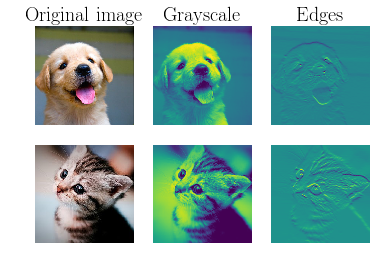

In [250]:
from skimage.io import imread
from skimage.transform import resize

kitten, puppy = imread('kitten.jpg'), imread('puppy.jpg')
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2:-d//2, :]

img_size = 200   # Make this smaller if it runs too slow
X = np.zeros((2, 3, img_size, img_size))
X[0, :, :, :] = resize(puppy, (img_size, img_size), mode='reflect').transpose((2, 0, 1))
X[1, :, :, :] = resize(kitten_cropped, (img_size, img_size), mode='reflect').transpose((2, 0, 1))

# Set up a convolutional weights holding 2 filters, each 3x3
W = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
W[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
W[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
W[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
W[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
conv = Convolution(2, filter_size=(3, 3), stride=1, padding=1, W_init=W, b_init=b, method='corr')
conv.initialize({'input_shape': X.shape})
out = conv.forward(X)

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_noax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_noax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_noax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_noax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_noax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_noax(out[1, 1])
plt.show()

<a id='cnn_conv_back'></a>
### X.X.X Convolution: Naive backward pass [[toc](#toc)]
Implement the backward pass for the convolution operation in the function `conv_backward_naive` in the file `cs231n/layers.py`. Again, you don't need to worry too much about computational efficiency.

When you are done, run the following to check your backward pass with a numeric gradient check.

In [326]:
# Your errors should be around 1e-8'
np.random.seed(231)
n_samples = 4; n_channels = 3; input_h = input_w = 5
n_filters = 2; filter_h = filter_w = 3
X = np.random.randn(n_samples, n_channels, input_h, input_w)
W = np.random.randn(n_filters, n_channels, filter_h, filter_w)
b = np.random.randn(n_filters,)
grad_Y = np.random.randn(n_samples, n_filters, 5, 5)
grad_checker = GradientsChecker()
for method in ['naive', 'corr', 'fast']:
    print('Considering method "{}"'.format(method))
    conv = Convolution(n_filters=n_filters, filter_size=(filter_h, filter_w), stride=1, padding=1,
                       W_init=W, b_init=b, method=method)
    conv.initialize({'input_shape': X.shape})
    grad_checker.eval_gradients(conv, X, grad_Y)
    print()

Considering method "naive"
grad_Convolution0:W error = 2.247109434939654e-10
grad_Convolution0:b error = 3.3726153958780465e-11
grad_X error = 1.159803161159293e-08

Considering method "corr"
grad_Convolution0:W error = 3.7332016776656607e-10
grad_Convolution0:b error = 1.1987307048126593e-10
grad_X error = 8.313436777798198e-09

Considering method "fast"
grad_Convolution0:W error = 1.794673097886394e-10
grad_Convolution0:b error = 2.584820872913033e-11
grad_X error = 1.5742701970585327e-08



In [330]:
np.random.seed(100)
n_samples = 10
n_channels = 3; n_filters = 3
input_h = 250; input_w = 250
filter_h = filter_w = 10
stride = 1; padding = (1, 0)
output_h = (input_h + padding[0] + padding[1] - filter_h) // stride + 1
output_w = (input_w + padding[0] + padding[1] - filter_w) // stride + 1
X      = np.random.randn(n_samples, n_channels, input_h, input_w)
grad_Y = np.random.randn(n_samples, n_filters, output_h, output_w)

for method in ['corr', 'fast']:
    print('Considering method "{}"'.format(method))
    conv = Convolution(n_filters=n_filters, filter_size=(filter_h, filter_w), stride=stride, padding=padding,
                       method=method)
    conv.initialize({'input_shape': (-1, n_channels, input_h, input_w), 'seed': 1})
    #print('\tpadding =', conv.padding)
    #grad_checker = GradientsChecker(batch_size=n_samples, seed=231)
    #grad_checker.eval_gradients()
    t1 = time()
    conv.forward(X)
    conv.backward(X, grad_Y)
    t2 = time()
    print('time = {}'.format(t2 - t1))

Considering method "corr"
time = 4.285311698913574
Considering method "fast"
time = 2.5441887378692627


<a id='cnn_max_pooling'></a>
## X.X Max pooling [[toc](#toc)]

In [331]:
from ml.neural_network.cs231n.second.conv_layers_fast import *

class MaxPooling(Layer):
    def __init__(self, pool_size=(2, 2), stride=(2, 2), padding=None, method='naive', name=None):
        super().__init__(name=name)
        if isinstance(pool_size, int):
            pool_size = (pool_size, pool_size)
        self.pool_size = pool_size
        if isinstance(stride, int):
            stride = (stride, stride)
        self.stride = stride
        self.padding = padding
        assert method in ['naive', 'fast']
        self.method = method
        if self.method == 'naive':
            self.update_output = self._update_output_naive
            self.update_grad_input = self._update_grad_input_naive
        elif self.method == 'fast':
            self.update_output = self._update_output_fast
            self.update_grad_input = self._update_grad_input_fast
            assert self.stride[0] == self.stride[1]
            self.pool_params = {'pool_height': self.pool_size[0],
                                'pool_width': self.pool_size[1],
                                'stride': self.stride[0]}
        else:
            assert False
    
    # INITIALIZATION
    def _initialize_input_shape(self, params):
        assert 'input_shape' in params
        input_shape = params['input_shape']
        assert len(input_shape) == 4
        _, n_channels, input_h, input_w = input_shape
        self.input_shape = (-1, n_channels, input_h, input_w)
    
    def _initialize_params(self, params):
        self._initialize_padding(params) # Это костыль
        return params
    def _initialize_padding(self, params):
        _, _, input_h, input_w = self.input_shape
        stride_h, stride_w = self.stride
        pool_h, pool_w = self.pool_size
        if self.padding is None:
            self.padding, _ = find_2d_padding((input_h, input_w), self.pool_size, self.stride)
        else:
            if isinstance(self.padding, (int, tuple)):
                self.padding = [self.padding, self.padding]
            self.padding = parse_padding(self.padding)
        (low_pad, upp_pad), (left_pad, right_pad) = self.padding
        self.use_padding = False
        if (low_pad > 0) | (upp_pad > 0) | (left_pad > 0) | (right_pad > 0):
            self.use_padding = True
        assert (input_h + low_pad + upp_pad - pool_h) % stride_h == 0
        assert (input_w + left_pad + right_pad - pool_w) % stride_w == 0
        return params
    
    def _initialize_output_shape(self, params):
        n_samples, n_channels, input_h, input_w = self.input_shape
        stride_h, stride_w = self.stride
        pool_h, pool_w = self.pool_size
        (low_pad, upp_pad), (left_pad, right_pad) = self.padding
        output_h = (input_h + low_pad + upp_pad - pool_h) // stride_h + 1
        output_w = (input_w + left_pad + right_pad - pool_w) // stride_w + 1 
        self.output_shape = (n_samples, n_channels, output_h, output_w)
        params['input_shape'] = self.output_shape
        return params

    def _update_output_naive(self, input):
        assert input.shape[1:] == self.input_shape[1:]
        n_samples, n_channels, input_h, output_w = input.shape
        _, n_channels, output_h, output_w = self.output_shape
        pool_h, pool_w = self.pool_size
        stride_h, stride_w = self.stride
 
        self.output = np.zeros((n_samples, n_channels, output_h, output_w), dtype=self.dtype)
        self.mask = np.zeros((n_samples, n_channels, output_h, output_w, 2), dtype=np.int32)
        for n_sample, n_channel in product(range(n_samples), range(n_channels)):
            input_slice = np.pad(input[n_sample, n_channel], self.padding, mode='constant')
            output_slice = self.output[n_sample, n_channel]
            mask_slice = self.mask[n_sample, n_channel]
            for i, j in product(range(output_h), range(output_w)):
                x = input_slice[i * stride_h : i * stride_h + pool_h, j * stride_w : j * stride_w + pool_w]
                h, w = np.unravel_index(np.argmax(x), x.shape)
                output_slice[i, j] = x[h, w]
                mask_slice[i, j] = np.array([h + i * stride_h, w + j * stride_w])
    def _update_grad_input_naive(self, input, grad_output):
        assert input.shape[1:] == self.input_shape[1:]
        assert grad_output.shape[1:] == self.output_shape[1:]
        n_samples, n_channels, image_h, image_w = input.shape
        _, n_channels, output_h, output_w = self.output_shape
        pool_h, pool_w = self.pool_size
        stride_h, stride_w = self.stride
        (pad_low, pad_upp), (pad_left, pad_right) = self.padding
        
        self.grad_input = np.zeros(input.shape, dtype=self.dtype)
        for n_sample, n_channel in product(range(n_samples), range(n_channels)):
            grad_input_slice = self.grad_input[n_sample, n_channel]
            grad_output_slice = grad_output[n_sample, n_channel]
            mask_slice = self.mask[n_sample, n_channel]
            for i, j in product(range(output_h), range(output_w)):
                h, w = mask_slice[i, j]
                grad_input_slice[h - pad_low, w - pad_left] = grad_output_slice[i, j]
            
    def _update_output_fast(self, input):
        if self.use_padding:
            pad_h, pad_w = self.padding
            input = np.pad(input, [(0, 0), (0, 0), pad_h, pad_w], mode='constant')
        self.output, self.cache = max_pool_forward_fast(input, self.pool_params)
    def _update_grad_input_fast(self, input, grad_output):
        self.grad_input = max_pool_backward_fast(grad_output, self.cache)
        if self.use_padding:
            (pad_low, pad_upp), (pad_left, pad_right) = self.padding
            _, _, padded_input_h, padded_input_w = self.grad_input.shape
            self.grad_input =\
                self.grad_input[:, :, pad_low:padded_input_h - pad_upp, pad_left:padded_input_w - pad_right]

<a id='cnn_max_pooling_forw'></a>
### X.X.X Max pooling: Naive forward  [[toc](#toc)]
Implement the forward pass for the max-pooling operation in the function `max_pool_forward_naive` in the file `cs231n/layers.py`. Again, don't worry too much about computational efficiency.

Check your implementation by running the following:

In [332]:
n_samples = 2; n_channels = 3; input_h = input_w = 4
input_shape = (n_samples, n_channels, input_h, input_w)
input = np.linspace(-0.3, 0.4, num=np.prod(input_shape)).reshape(input_shape)
max_pool = MaxPooling(pool_size=(2, 2), stride=2, method='fast')
print(max_pool.initialize({'input_shape': input.shape}))
out = max_pool.forward(input)
correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare your output with ours. Difference should be around 1e-8.
print('Testing max_pool_forward_naive function:')
print('difference: ', rel_error(out, correct_out))

{'debug': False, 'grad_clip': inf, 'seed': 0, 'dtype': <class 'numpy.float64'>, 'input_shape': (-1, 3, 2, 2), 'names': {'MaxPooling': 1}}
Testing max_pool_forward_naive function:
difference:  4.16666651573e-08


<a id='cnn_max_pooling_back'></a>
### 2.2.2 Max pooling: Naive backward [[toc](#toc)]
Implement the backward pass for the max-pooling operation in the function `max_pool_backward_naive` in the file `cs231n/layers.py`. You don't need to worry about computational efficiency.

Check your implementation with numeric gradient checking by running the following:

In [333]:
# Your error should be around 1e-12
np.random.seed(232)
n_samples = 3; n_channels = 2; input_h = input_w = 8
n_filters = 2
input = np.random.randn(n_samples, n_channels, input_h, input_w)
grad_output = np.random.randn(n_samples, n_filters, 4, 4)
max_pool = MaxPooling(pool_size=(2, 2), stride=2, method='fast')
print(max_pool.initialize({'input_shape': input.shape}))
grad_checker = GradientsChecker(verbose=True)
grad_checker.eval_gradients(max_pool, input, grad_output)

{'debug': False, 'grad_clip': inf, 'seed': 0, 'dtype': <class 'numpy.float64'>, 'input_shape': (-1, 2, 4, 4), 'names': {'MaxPooling': 1}}
grad_X error = 3.2756158125805727e-12


<a id='cnn_fast'></a>
## 2.3 Fast layers [[toc](#toc)]
Making convolution and pooling layers fast can be challenging. To spare you the pain, we've provided fast implementations of the forward and backward passes for convolution and pooling layers in the file `cs231n/fast_layers.py`.

The fast convolution implementation depends on a Cython extension; to compile it you need to run the following from the `cs231n` directory:

```bash
python setup.py build_ext --inplace
```

The API for the fast versions of the convolution and pooling layers is exactly the same as the naive versions that you implemented above: the forward pass receives data, weights, and parameters and produces outputs and a cache object; the backward pass recieves upstream derivatives and the cache object and produces gradients with respect to the data and weights.

**NOTE:** The fast implementation for pooling will only perform optimally if the pooling regions are non-overlapping and tile the input. If these conditions are not met then the fast pooling implementation will not be much faster than the naive implementation.

You can compare the performance of the naive and fast versions of these layers by running the following:

In [344]:
from time import time
np.random.seed(231)
n_filters = 25
X = np.random.randn(100, 3, 31, 31)
W = np.random.randn(n_filters, 3, 3, 3)
b = np.random.randn(n_filters,)
grad_Y = np.random.randn(100, n_filters, 16, 16)

conv_naive = Convolution(n_filters=n_filters, filter_size=(3, 3), stride=2, padding=1, method='naive',
                  W_init=W, b_init=b)
conv_naive.initialize({'input_shape': X.shape})

conv_corr = Convolution(n_filters=n_filters, filter_size=(3, 3), stride=2, padding=1, method='corr',
                  W_init=W, b_init=b)
conv_corr.initialize({'input_shape': X.shape})

conv_fast = Convolution(n_filters=n_filters, filter_size=(3, 3), stride=2, padding=1, method='fast',
                  W_init=W, b_init=b)
conv_fast.initialize({'input_shape': X.shape})


t0 = time()
out_naive = conv_naive.forward(X)
t1 = time()
out_corr  = conv_corr.forward(X)
t2 = time()
out_fast  = conv_fast.forward(X)
t3 = time()

print('Testing conv forward fast:')
print('Naive: %fs' % (t1 - t0))
print('Corr: %fs' % (t2 - t1))
print('Fast: %fs' % (t3 - t2))
print('Speedup naive/fast: %fx' % ((t1 - t0) / (t3 - t2)))
print('Speedup corr/fast : %fx' % ((t2 - t1) / (t3 - t2)))
print('Difference: ', rel_error(out_naive, out_fast))

t0 = time()
grad_X_naive = conv_naive.backward(X, grad_Y)
grad_W_naive = conv_naive.grad_W
grad_b_naive = conv_naive.grad_b
t1 = time()
grad_X_corr = conv_corr.backward(X, grad_Y)
grad_W_corr = conv_corr.grad_W
grad_b_corr = conv_corr.grad_b
t2 = time()
grad_X_fast = conv_fast.backward(X, grad_Y)
grad_W_fast = conv_fast.grad_W
grad_b_fast = conv_fast.grad_b
t3 = time()

print('\nTesting conv_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Corr: %fs' % (t2 - t1))
print('Fast: %fs' % (t3 - t2))
print('Speedup naive/fast: %fx' % ((t1 - t0) / (t3 - t2)))
print('Speedup corr/fast : %fx' % ((t2 - t1) / (t3 - t2)))
print('grad_X difference: ', rel_error(grad_X_naive, grad_X_fast), rel_error(grad_X_corr, grad_X_fast))
print('grad_W difference: ', rel_error(grad_W_naive, grad_W_fast), rel_error(grad_W_corr, grad_W_fast))
print('grad_b difference: ', rel_error(grad_b_naive, grad_b_fast), rel_error(grad_b_corr, grad_b_fast))

Testing conv forward fast:
Naive: 0.263715s
Corr: 0.786761s
Fast: 0.019613s
Speedup naive/fast: 13.445923x
Speedup corr/fast : 40.114195x
Difference:  1.97056314066e-11

Testing conv_backward_fast:
Naive: 9.427876s
Corr: 0.549996s
Fast: 0.011914s
Speedup naive/fast: 791.342385x
Speedup corr/fast : 46.164699x
grad_X difference:  2.0126604133e-11 6.71882775605e-12
grad_W difference:  2.57766409929e-13 1.0846683861e-13
grad_b difference:  3.13938580256e-15 5.83028791903e-15


In [346]:
np.random.seed(231)
X = np.random.randn(100, 3, 32, 32)
grad_Y = np.random.randn(100, 3, 16, 16)

pool_naive = MaxPooling(pool_size=(2, 2), stride=2, method='naive')
pool_naive.initialize({'input_shape': X.shape})
pool_fast = MaxPooling(pool_size=(2, 2), stride=2, method='fast')
pool_fast.initialize({'input_shape': X.shape})

t0 = time()
out_naive = pool_naive.forward(X)
t1 = time()
out_fast = pool_fast.forward(X)
t2 = time()

print('Testing conv forward fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup naive/fast: %fx' % ((t1 - t0) / (t2 - t1)))
print('Difference: ', rel_error(out_naive, out_fast))

t0 = time()
grad_X_naive = pool_naive.backward(X, grad_Y)
t1 = time()
grad_X_fast = pool_fast.backward(X, grad_Y)
t2 = time()

print('\nTesting conv_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup naive/fast: %fx' % ((t1 - t0) / (t2 - t1)))
print('grad_X difference: ', rel_error(grad_X_naive, grad_X_fast))

Testing conv forward fast:
Naive: 0.559774s
Fast: 0.015958s
Speedup naive/fast: 35.078318x
Difference:  0.0

Testing conv_backward_fast:
Naive: 0.441948s
Fast: 0.021536s
Speedup naive/fast: 20.521466x
grad_X difference:  0.0


<a id='cnn_spatial'></a>
## 2.5 Spatial Batch Normalization [[toc](#toc)]
We already saw that batch normalization is a very useful technique for training deep fully-connected networks. Batch normalization can also be used for convolutional networks, but we need to tweak it a bit; the modification will be called "spatial batch normalization."

Normally batch-normalization accepts inputs of shape `(N, D)` and produces outputs of shape `(N, D)`, where we normalize across the minibatch dimension `N`. For data coming from convolutional layers, batch normalization needs to accept inputs of shape `(N, C, H, W)` and produce outputs of shape `(N, C, H, W)` where the `N` dimension gives the minibatch size and the `(H, W)` dimensions give the spatial size of the feature map.

If the feature map was produced using convolutions, then we expect the statistics of each feature channel to be relatively consistent both between different imagesand different locations within the same image. Therefore spatial batch normalization computes a mean and variance for each of the `C` feature channels by computing statistics over both the minibatch dimension `N` and the spatial dimensions `H` and `W`.

In [364]:
class SpatialBatchNormalization(BatchNormalization):
    def __init__(self, momentum=0.9, eps=1e-5, name=None):
        super().__init__(momentum=momentum, eps=eps, name=name)
    def _initialize_input_shape(self, params):
        input_shape = params['input_shape']
        assert len(input_shape) == 4
        _, n_channels, input_h, input_w = input_shape
        self.input_shape = (-1, n_channels, input_h, input_w)
    
    def forward_reshape(self, X):
        assert X.shape[1:] == self.input_shape[1:]
        n_samples, n_channels, input_h, input_w = self.input_shape 
        return np.transpose(X, [0, 2, 3, 1]).reshape((-1, n_channels))
        
    def backward_reshape(self, X):
        n_samples, n_channels, input_h, input_w = self.input_shape 
        return X.reshape((n_samples, input_h, input_w, n_channels)).transpose([0, 3, 1, 2])
    @check_initialized
    @dtype_conversion
    def forward(self, input):
        self.input = self.forward_reshape(input)
        super().forward(self.input)
        self.output = self.backward_reshape(self.output)
        return self.output
    @check_initialized
    @dtype_conversion
    def backward(self, input, grad_output):
        super().backward(self.input, self.forward_reshape(grad_output))
        self.grad_input = self.backward_reshape(self.grad_input)
        return self.grad_input
    
class Flatten(Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
    def _initialize_input_shape(self, params):
        input_shape = params['input_shape']
        assert len(input_shape) == 4
        _, n_channels, input_h, input_w = input_shape
        self.input_shape = (-1, n_channels, input_h, input_w)
        return params
    def _initialize_output_shape(self, params):
        input_shape = params['input_shape']
        _, n_channels, input_h, input_w = input_shape
        self.output_shape = (-1, n_channels * input_h * input_w)
        params['input_shape'] = self.output_shape
        return params
    
    def update_output(self, input):
        self.output = input.reshape(self.output_shape)
    
    def update_grad_input(self, input, grad_output):
        self.grad_input = grad_output.reshape(self.input_shape)

<a id='cnn_spatial_forw'></a>
### 2.5.1 Spatial batch normalization: forward [[toc](#toc)]

In the file `cs231n/layers.py`, implement the forward pass for spatial batch normalization in the function `spatial_batchnorm_forward`. Check your implementation by running the following:

In [356]:
np.random.seed(231)
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 3, 4, 5
X = 4 * np.random.randn(N, C, H, W) + 10

print('Before spatial batch normalization:')
print('  Shape: ', X.shape)
print('  Means: ', X.mean(axis=(0, 2, 3)))
print('  Stds: ', X.std(axis=(0, 2, 3)))

# Means should be close to zero and stds close to one
gamma, beta = np.ones(C), np.zeros(C)
bn = SpatialBatchNormalization()
bn.initialize({'input_shape': X.shape})
bn.gamma = gamma; bn.beta = beta
out = bn.forward(X)

print('After spatial batch normalization:')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ',  out.std(axis=(0, 2, 3)))

# Means should be close to beta and stds close to gamma
gamma, beta = np.asarray([3, 4, 5]), np.asarray([6, 7, 8])
bn.gamma = gamma; bn.beta = beta
out = bn.forward(X)
print('After spatial batch normalization (nontrivial gamma, beta):')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ',  out.std(axis=(0, 2, 3)))

Before spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [ 9.33463814  8.90909116  9.11056338]
  Stds:  [ 3.61447857  3.19347686  3.5168142 ]
After spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [  6.18949336e-16   5.99520433e-16  -1.22124533e-16]
  Stds:  [ 0.99999962  0.99999951  0.9999996 ]
After spatial batch normalization (nontrivial gamma, beta):
  Shape:  (2, 3, 4, 5)
  Means:  [ 6.  7.  8.]
  Stds:  [ 2.99999885  3.99999804  4.99999798]


In [357]:
np.random.seed(231)
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.
N, C, H, W = 10, 4, 11, 12

bn = SpatialBatchNormalization()
bn.initialize({'input_shape': (N, C, H, W)})
bn.train()
for t in range(50):
    X = 2.3 * np.random.randn(N, C, H, W) + 13
    bn.forward(X)

bn.evaluate()
X = 2.3 * np.random.randn(N, C, H, W) + 13
a_norm = bn.forward(X)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After spatial batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=(0, 2, 3)))
print('  stds: ',  a_norm.std(axis=(0, 2, 3)))

After spatial batch normalization (test-time):
  means:  [-0.08034406  0.07562881  0.05716371  0.04378383]
  stds:  [ 0.96718744  1.0299714   1.02887624  1.00585577]


<a id='cnn_spatial_back'></a>
### 2.5.2 Spatial batch normalization: backward [[toc](#toc)]
In the file `cs231n/layers.py`, implement the backward pass for spatial batch normalization in the function `spatial_batchnorm_backward`. Run the following to check your implementation using a numeric gradient check:

In [359]:
np.random.seed(231)
N, C, H, W = 2, 3, 4, 5
X = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(C)
beta = np.random.randn(C)
dout = np.random.randn(N, C, H, W)

bn = SpatialBatchNormalization()
bn.initialize({'input_shape': (N, C, H, W)})
bn.train()

grad_checker = GradientsChecker()
grad_checker.eval_gradients(bn)

grad_SpatialBatchNormalization0:gamma error = 1.8246042271044925e-11
grad_SpatialBatchNormalization0:beta error = 5.80633620907433e-12
grad_X error = 1.9921105304167864e-08


<a id='cnn_three'></a>
## 2.6 Three-layer ConvNet  [[toc](#toc)]
Now that you have implemented all the necessary layers, we can put them together into a simple convolutional network.

Open the file `cs231n/classifiers/cnn.py` and complete the implementation of the `ThreeLayerConvNet` class. Run the following cells to help you debug:

In [385]:
def make_three_layer_cnn(n_filters=32, filter_size=7, conv_stride=1, 
                        pool_size=2, pool_stride=2,
                        hidden_size=100, n_classes=10,
                        l2_reg=0.0, dropout=0.0,
                        use_batchnorm=False):
    W_reg = None
    use_dropout = False
    if l2_reg > 0:
        W_reg = L2Regularizer(l2_reg)
    if dropout > 0:
        use_dropout = True
    layers = []
    layers.append(Convolution(n_filters=n_filters, filter_size=filter_size, stride=conv_stride, W_reg=W_reg))
    if use_batchnorm:
        layers.append(SpatialBatchNormalization())
    layers.append(ReLU())
    layers.append(MaxPooling(pool_size=pool_size, stride=pool_stride))  
    if use_dropout:
        layers.append(Dropout(dropout))
    layers.append(Flatten())
    layers.append(Dense(hidden_size, W_reg=W_reg))
    layers.append(ReLU())
    if use_dropout:
        layers.append(Dropout(dropout))
    layers.append(Dense(n_classes, W_reg=W_reg))
    layers.append(SoftMax())
    return model(layers, MulticlassLogLoss())

<a id='cnn_three_sanity'></a>
### 2.6.1 Sanity check loss [[toc](#toc)]
After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization this should go up.

In [ ]:
model = make_three_layer_cnn()

N = 50
np.random.seed(231)
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

<a id='cnn_three_grad'></a>
### 2.6.2 Gradient check [[toc](#toc)]
After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer. Note: correct implementations may still have relative errors up to 1e-2.

In [394]:
n_samples = 2
input_dim = (3, 16, 16)
l2_reg = 0.0
n_classes = 10
np.random.seed(231)
X = np.random.randn(n_samples, *input_dim)
y = np.random.randint(n_classes, size=n_samples)

model = make_three_layer_cnn(n_filters=3, filter_size=3, hidden_size=7, l2_reg=l2_reg)
model.compile(input_shape=X.shape)

grad_checker = GradientsChecker()
grad_checker.eval_gradients(model)

AssertionError: 

<a id='cnn_three_overfit'></a>
### 2.6.3 Overfit small data [[toc](#toc)]
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [381]:
small_dataset = dataset.get_small_train_dataset(100)
model = get_three_layer_cnn()
solver = Solver(model, small_dataset,
                n_epochs=15, batch_size=50,
                optim_config={
                    'update_rule': 'adam',
                    'learning_rate': 3e-3,
                    'learning_rate_decay': 0.99
                },
                verbose=True, 
                print_every_epoch=1, seed=2)
print(model)
model = solver.train()

Convolution->ReLU->MaxPooling->Flatten->Dense(5408->100)->ReLU->Dense(100->10)->SoftMax->[MulticlassLogLoss]
Convolution->ReLU->MaxPooling->Flatten->Dense(5408->100)->ReLU->Dense(100->10)->SoftMax->[MulticlassLogLoss]
num of epochs = 15
num of iterations = 30
iterations per epoch = 2
(Epoch 1/15) train acc: 0.28; val acc: 0.2, train loss: 2.214; val loss: 2.666
(Epoch 2/15) train acc: 0.39; val acc: 0.15, train loss: 1.78; val loss: 2.717
(Epoch 3/15) train acc: 0.56; val acc: 0.18, train loss: 1.445; val loss: 2.47
(Epoch 4/15) train acc: 0.67; val acc: 0.2, train loss: 1.225; val loss: 2.391
(Epoch 5/15) train acc: 0.77; val acc: 0.21, train loss: 0.9974; val loss: 2.502
(Epoch 6/15) train acc: 0.8; val acc: 0.21, train loss: 0.8263; val loss: 2.805
(Epoch 7/15) train acc: 0.81; val acc: 0.21, train loss: 0.6837; val loss: 3.038
(Epoch 8/15) train acc: 0.87; val acc: 0.23, train loss: 0.5035; val loss: 2.977
(Epoch 9/15) train acc: 0.93; val acc: 0.23, train loss: 0.3894; val loss: 3

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

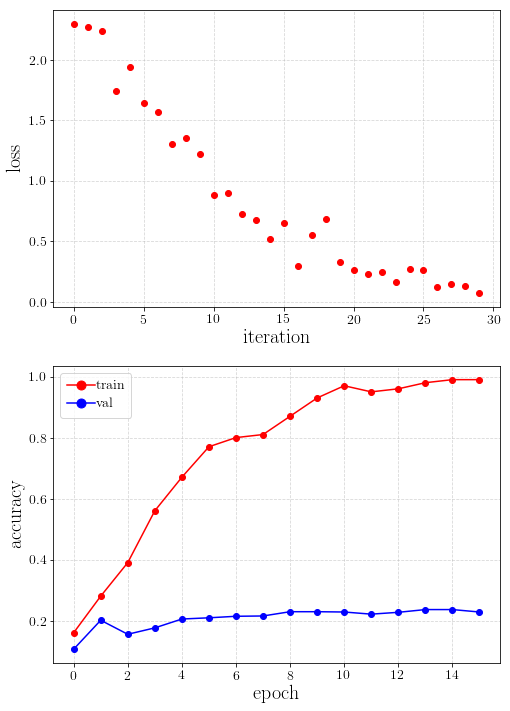

In [383]:
plt.figure(figsize=(8, 12))
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o', color='r', zorder=2)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.grid(linestyle='--', alpha=0.5)

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o', color='r', zorder=2)
plt.plot(solver.val_acc_history, '-o', color='b', zorder=2)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(linestyle='--', alpha=0.5)
plt.show()

<a id='cnn_three_train'></a>
### 2.6.4 Train net [[toc](#toc)]
By training the three-layer convolutional network for one epoch, you should achieve greater than 40% accuracy on the training set:

In [396]:
model = get_three_layer_cnn(hidden_size=200)
solver = Solver(model, dataset,
                n_epochs=1, batch_size=50,
                optim_config={
                    'update_rule': 'adam',
                    'learning_rate': 1e-3,
                    'learning_rate_decay': 0.99
                },
                verbose=False, 
                print_every_epoch=1, print_every_iter=20, seed=2)
print(model)
model = solver.train()

Convolution->ReLU->MaxPooling->Flatten->Dense(5408->200)->ReLU->Dense(200->10)->SoftMax->[MulticlassLogLoss]
(Iteration 20/980) loss: 2.0403768313700885
(Iteration 40/980) loss: 2.088498242587525
(Iteration 60/980) loss: 1.6283328598751796
(Iteration 80/980) loss: 1.5983530158748567
(Iteration 100/980) loss: 1.7741148135901224
(Iteration 120/980) loss: 1.369041287600161
(Iteration 140/980) loss: 1.5144133921956928
(Iteration 160/980) loss: 1.2436301876730813
(Iteration 180/980) loss: 1.5834090497380393
(Iteration 200/980) loss: 1.6842583709391612
(Iteration 220/980) loss: 1.3397357810427892
(Iteration 240/980) loss: 1.6163857987496288
(Iteration 260/980) loss: 1.4386532623603758
(Iteration 280/980) loss: 1.2418892509375046
(Iteration 300/980) loss: 1.4257474217258634
(Iteration 320/980) loss: 1.2898296539419434
(Iteration 340/980) loss: 1.3796715118384058
(Iteration 360/980) loss: 1.43356563475733
(Iteration 380/980) loss: 1.580577409632258
(Iteration 400/980) loss: 1.4075579296442884


In [399]:
probas = model.forward(data['X_val'])
y_pred = np.argmax(probas, axis=1)
y_true = data['y_val']
print(np.mean(y_pred == y_true))

0.6


<a id='cnn_three_visualize'></a>
### 2.6.5 Visualize filters [[toc](#toc)]
You can visualize the first-layer convolutional filters from the trained network by running the following:

(32, 7, 7, 3)


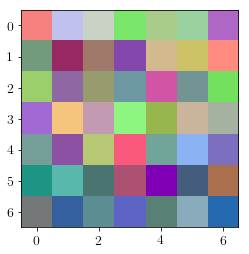

In [413]:
W = model[0].W.transpose(0, 2, 3, 1)
print(W.shape)
w = (W[0] - np.min(W[0]))/ (np.max(W[0]) - np.min(W[0]))
plt.imshow(w)

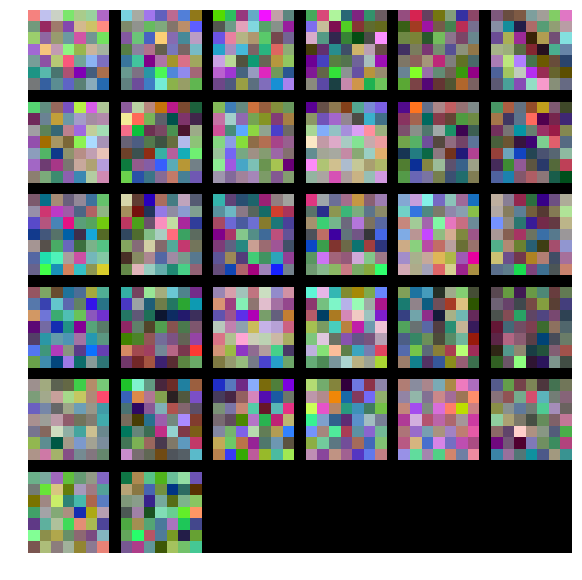

In [398]:
from ml.utils.vis_utils import visualize_grid

grid = visualize_grid(model[0].W.transpose(0, 2, 3, 1), n_cols=6)
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(10, 10)
plt.show()

## Extra Credit Description [[toc](#toc)]
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable.